Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
# Already Wrangled Project 2 dataset
df = pd.read_csv('https://raw.githubusercontent.com/John-G-Thomas/Projects/master/Project2DF.csv')
df.set_index(pd.to_datetime(df['Datetime']), inplace = True)
print(df.shape)
df.head()

(3148, 12)


,Datetime,LandAverageTemperatureUncertainty,UpperBounds,LowerBounds,month,year,Average_Temperature,Yearly_SMA,Decade_SMA,Semicentennial_SMA,Centurie,Global_Warming
Datetime,,,,,,,,,,,,
1750-01-01,1750-01-01,3.574,6.608,-0.540,1,1750,3.034,NaN,NaN,NaN,NaN,0
1750-02-01,1750-02-01,3.702,6.785,-0.619,2,1750,3.083,NaN,NaN,NaN,NaN,0
1750-03-01,1750-03-01,3.076,8.702,2.550,3,1750,5.626,NaN,NaN,NaN,NaN,0
1750-04-01,1750-04-01,2.451,10.941,6.039,4,1750,8.490,NaN,NaN,NaN,NaN,1
1750-05-01,1750-05-01,2.072,13.645,9.501,5,1750,11.573,NaN,NaN,NaN,NaN,1


In [4]:
morefeatures = pd.read_csv('https://pkgstore.datahub.io/core/co2-fossil-global/global_csv/data/09015539c2fc32bb3c4afead7df461b5/global_csv.csv')
morefeatures.fillna(0, inplace=True)
print(morefeatures.shape)
morefeatures.head(10)

(260, 8)


,Year,Total,Gas Fuel,Liquid Fuel,Solid Fuel,Cement,Gas Flaring,Per Capita
0,1751,3,0,0,3,0,0,0.0
1,1752,3,0,0,3,0,0,0.0
2,1753,3,0,0,3,0,0,0.0
3,1754,3,0,0,3,0,0,0.0
4,1755,3,0,0,3,0,0,0.0
5,1756,3,0,0,3,0,0,0.0
6,1757,3,0,0,3,0,0,0.0
7,1758,3,0,0,3,0,0,0.0
8,1759,3,0,0,3,0,0,0.0
9,1760,3,0,0,3,0,0,0.0


In [5]:
morefeatures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         260 non-null    int64  
 1   Total        260 non-null    int64  
 2   Gas Fuel     260 non-null    int64  
 3   Liquid Fuel  260 non-null    int64  
 4   Solid Fuel   260 non-null    int64  
 5   Cement       260 non-null    int64  
 6   Gas Flaring  260 non-null    int64  
 7   Per Capita   260 non-null    float64
dtypes: float64(1), int64(7)
memory usage: 16.4 KB


In [6]:
df=df.rename(columns={'year': 'Year'})
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3148 entries, 1750-01-01 to 2015-12-01
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Datetime                           3148 non-null   object 
 1   LandAverageTemperatureUncertainty  3148 non-null   float64
 2   UpperBounds                        3148 non-null   float64
 3   LowerBounds                        3148 non-null   float64
 4   month                              3148 non-null   int64  
 5   Year                               3148 non-null   int64  
 6   Average_Temperature                3148 non-null   float64
 7   Yearly_SMA                         3137 non-null   float64
 8   Decade_SMA                         3029 non-null   float64
 9   Semicentennial_SMA                 2549 non-null   float64
 10  Centurie                           1949 non-null   float64
 11  Global_Warming                     314

- Mearge Two DataFrames

In [7]:
X = pd.merge(df, morefeatures, how='inner')
X.set_index(pd.to_datetime(X['Datetime']), inplace = True)
X.drop('Datetime', axis=1, inplace=True)
print(X.shape)
X.tail(10)

(3079, 18)


,LandAverageTemperatureUncertainty,UpperBounds,LowerBounds,month,Year,Average_Temperature,Yearly_SMA,Decade_SMA,Semicentennial_SMA,Centurie,Global_Warming,Total,Gas Fuel,Liquid Fuel,Solid Fuel,Cement,Gas Flaring,Per Capita
Datetime,,,,,,,,,,,,,,,,,,
2010-03-01,0.057,6.795,6.681,3,2010,6.738,9.589167,9.506567,8.977185,8.765650,0,9167,1702,3114,3842,450,59,1.33
2010-04-01,0.087,9.758,9.584,4,2010,9.671,9.614500,9.507558,8.979748,8.766955,1,9167,1702,3114,3842,450,59,1.33
2010-05-01,0.078,12.484,12.328,5,2010,12.406,9.639000,9.511992,8.982305,8.768122,1,9167,1702,3114,3842,450,59,1.33
2010-06-01,0.086,14.507,14.335,6,2010,14.421,9.657333,9.515000,8.983867,8.769181,1,9167,1702,3114,3842,450,59,1.33
2010-07-01,0.090,15.303,15.123,7,2010,15.213,9.655833,9.518042,8.985558,8.769959,1,9167,1702,3114,3842,450,59,1.33
2010-08-01,0.112,14.880,14.656,8,2010,14.768,9.665250,9.520117,8.987130,8.770868,1,9167,1702,3114,3842,450,59,1.33
2010-09-01,0.065,12.928,12.798,9,2010,12.863,9.641083,9.522750,8.988410,8.771810,1,9167,1702,3114,3842,450,59,1.33
2010-10-01,0.070,10.512,10.372,10,2010,10.442,9.666583,9.530717,8.989985,8.773007,1,9167,1702,3114,3842,450,59,1.33
2010-11-01,0.102,7.589,7.385,11,2010,7.487,9.704583,9.540508,8.992750,8.774814,0,9167,1702,3114,3842,450,59,1.33


In [8]:
X['Yearly_SMA_Solid_Fuel'] = X[['Solid Fuel']].rolling(window=12).mean()
X['Yearly_SMA_Gas_Fuel'] = X[['Gas Fuel']].rolling(window=12).mean()
X['Yearly_SMA_Cement'] = X[['Cement']].rolling(window=12).mean()
X['Yearly_SMA_Gas_Flaring'] = X[['Gas Flaring']].rolling(window=12).mean()
X['Yearly_SMA_Per_Capita'] = X[['Per Capita']].rolling(window=12).mean()
X['Yearly_SMA_Liquid_Fuel'] = X[['Liquid Fuel']].rolling(window=12).mean()
X['Yearly_SMA_CarbonTotal'] = X[['Total']].rolling(window=12).mean()
X.drop('Semicentennial_SMA', axis=1, inplace=True)
X.drop('Centurie', axis=1, inplace=True)
X.dropna(subset=['Decade_SMA'], inplace=True)
X.drop('Total', axis=1, inplace=True)
X.drop('Gas Fuel', axis=1, inplace=True)
X.drop('Liquid Fuel', axis=1, inplace=True)
X.drop('Solid Fuel', axis=1, inplace=True)
X.drop('Gas Flaring', axis=1, inplace=True)
X.drop('Per Capita', axis=1, inplace=True)
X.drop('LandAverageTemperatureUncertainty', axis=1, inplace=True)
X.drop('UpperBounds', axis=1, inplace=True)
X.drop('LowerBounds', axis=1, inplace=True)
X.drop('Cement', axis=1, inplace=True)
X.drop('Average_Temperature', axis=1, inplace=True)
X.drop('Yearly_SMA', axis=1, inplace=True)

In [9]:
X.isnull().sum()

month                     0
Year                      0
Decade_SMA                0
Global_Warming            0
Yearly_SMA_Solid_Fuel     0
Yearly_SMA_Gas_Fuel       0
Yearly_SMA_Cement         0
Yearly_SMA_Gas_Flaring    0
Yearly_SMA_Per_Capita     0
Yearly_SMA_Liquid_Fuel    0
Yearly_SMA_CarbonTotal    0
dtype: int64

### 1) Continue to clean and explore your data. Make exploratory visualizations.

In [10]:
print(X.shape)
X.tail(10)

(2970, 11)


,month,Year,Decade_SMA,Global_Warming,Yearly_SMA_Solid_Fuel,Yearly_SMA_Gas_Fuel,Yearly_SMA_Cement,Yearly_SMA_Gas_Flaring,Yearly_SMA_Per_Capita,Yearly_SMA_Liquid_Fuel,Yearly_SMA_CarbonTotal
Datetime,,,,,,,,,,,
2010-03-01,3,2010,9.506567,0,3675.5,1614.25,422.250000,64.250000,1.292500,3070.500000,8846.750000
2010-04-01,4,2010,9.507558,1,3694.0,1624.00,425.333333,63.666667,1.296667,3075.333333,8882.333333
2010-05-01,5,2010,9.511992,1,3712.5,1633.75,428.416667,63.083333,1.300833,3080.166667,8917.916667
2010-06-01,6,2010,9.515000,1,3731.0,1643.50,431.500000,62.500000,1.305000,3085.000000,8953.500000
2010-07-01,7,2010,9.518042,1,3749.5,1653.25,434.583333,61.916667,1.309167,3089.833333,8989.083333
2010-08-01,8,2010,9.520117,1,3768.0,1663.00,437.666667,61.333333,1.313333,3094.666667,9024.666667
2010-09-01,9,2010,9.522750,1,3786.5,1672.75,440.750000,60.750000,1.317500,3099.500000,9060.250000
2010-10-01,10,2010,9.530717,1,3805.0,1682.50,443.833333,60.166667,1.321667,3104.333333,9095.833333
2010-11-01,11,2010,9.540508,0,3823.5,1692.25,446.916667,59.583333,1.325833,3109.166667,9131.416667


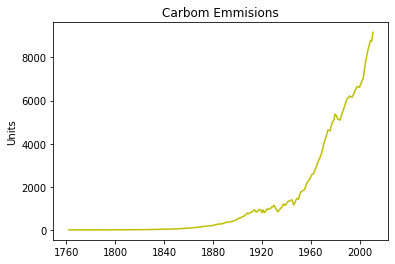

In [11]:
plt.plot(X['Yearly_SMA_CarbonTotal'], 'y')
plt.title('Carbom Emmisions')
plt.ylabel('Units');
plt.show();

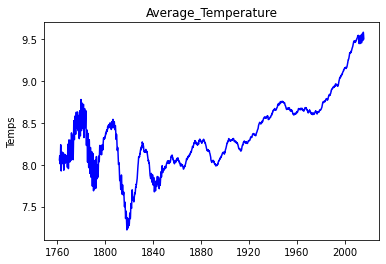

In [12]:
plt.plot(df['Decade_SMA'], 'b')
plt.title('Average_Temperature')
plt.ylabel('Temps');
plt.show();

In [13]:
# Baseline Global Warming .516162
X.describe()

,month,Year,Decade_SMA,Global_Warming,Yearly_SMA_Solid_Fuel,Yearly_SMA_Gas_Fuel,Yearly_SMA_Cement,Yearly_SMA_Gas_Flaring,Yearly_SMA_Per_Capita,Yearly_SMA_Liquid_Fuel,Yearly_SMA_CarbonTotal
count,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000
mean,6.518182,1886.620539,8.339950,0.516162,701.358418,191.401684,35.053535,13.615993,0.257497,515.093939,1456.495286
std,3.448389,71.651864,0.412514,0.499823,864.692458,398.277173,78.318491,26.648685,0.460562,942.592184,2258.948078
min,1.000000,1761.000000,7.220025,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,4.000000,1825.000000,8.054294,0.000000,16.354167,0.000000,0.000000,0.000000,0.000000,0.000000,16.354167
50%,7.000000,1887.000000,8.281392,1.000000,278.500000,2.000000,0.000000,0.000000,0.000000,5.000000,285.083333
75%,10.000000,1949.000000,8.629850,1.000000,1061.208333,76.729167,14.291667,0.000000,0.000000,362.291667,1439.104167
max,12.000000,2010.000000,9.544083,1.000000,3842.000000,1702.000000,450.000000,110.000000,1.330000,3122.000000,9167.000000


- Global warming determined if temperature increasing since start of greenhouse gases start of 1850 industrial revolution

In [14]:
select_year = X.loc[X['Year'] == 1850]
select_year.head(12)

,month,Year,Decade_SMA,Global_Warming,Yearly_SMA_Solid_Fuel,Yearly_SMA_Gas_Fuel,Yearly_SMA_Cement,Yearly_SMA_Gas_Flaring,Yearly_SMA_Per_Capita,Yearly_SMA_Liquid_Fuel,Yearly_SMA_CarbonTotal
Datetime,,,,,,,,,,,
1850-01-01,1,1850,7.963000,0,50.333333,0.0,0.0,0.0,0.0,0.0,50.333333
1850-02-01,2,1850,7.971075,0,50.666667,0.0,0.0,0.0,0.0,0.0,50.666667
1850-03-01,3,1850,7.978692,0,51.000000,0.0,0.0,0.0,0.0,0.0,51.000000
1850-04-01,4,1850,7.972642,0,51.333333,0.0,0.0,0.0,0.0,0.0,51.333333
1850-05-01,5,1850,7.962900,1,51.666667,0.0,0.0,0.0,0.0,0.0,51.666667
1850-06-01,6,1850,7.960725,1,52.000000,0.0,0.0,0.0,0.0,0.0,52.000000
1850-07-01,7,1850,7.958875,1,52.333333,0.0,0.0,0.0,0.0,0.0,52.333333
1850-08-01,8,1850,7.966817,1,52.666667,0.0,0.0,0.0,0.0,0.0,52.666667
1850-09-01,9,1850,7.970942,1,53.000000,0.0,0.0,0.0,0.0,0.0,53.000000


In [15]:
X['Global_Warming'] = (X['Decade_SMA']>= 7.963000)
X[["Global_Warming"]] *= 1

In [16]:
# New Basline Temperatures above decade SMA Global Temps before 1850(Industrial Revolution) -baseline .864983
X.describe()

,month,Year,Decade_SMA,Global_Warming,Yearly_SMA_Solid_Fuel,Yearly_SMA_Gas_Fuel,Yearly_SMA_Cement,Yearly_SMA_Gas_Flaring,Yearly_SMA_Per_Capita,Yearly_SMA_Liquid_Fuel,Yearly_SMA_CarbonTotal
count,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000
mean,6.518182,1886.620539,8.339950,0.864983,701.358418,191.401684,35.053535,13.615993,0.257497,515.093939,1456.495286
std,3.448389,71.651864,0.412514,0.341799,864.692458,398.277173,78.318491,26.648685,0.460562,942.592184,2258.948078
min,1.000000,1761.000000,7.220025,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,4.000000,1825.000000,8.054294,1.000000,16.354167,0.000000,0.000000,0.000000,0.000000,0.000000,16.354167
50%,7.000000,1887.000000,8.281392,1.000000,278.500000,2.000000,0.000000,0.000000,0.000000,5.000000,285.083333
75%,10.000000,1949.000000,8.629850,1.000000,1061.208333,76.729167,14.291667,0.000000,0.000000,362.291667,1439.104167
max,12.000000,2010.000000,9.544083,1.000000,3842.000000,1702.000000,450.000000,110.000000,1.330000,3122.000000,9167.000000


### 2) Fit a model. Does it beat your baseline?

- Train is before greenhouse gasses and zero emmisions
- Test is After greenhouse gasses and zero emmisions (Industrial Revolution)

In [17]:
#Spilt The Test Date
train = X[(X['Year']>=1751)&(X['Year']<1850)]
test = X[(X['Year']>=1850)&(X['Year']<=2010)]
print(X.shape)
print(train.shape)
print(test.shape)

(2970, 11)
(1038, 11)
(1932, 11)


In [18]:
# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['Global_Warming'],random_state=42)

In [19]:
print(X.shape)
print(train.shape)
print(val.shape)
print(test.shape)

(2970, 11)
(830, 11)
(208, 11)
(1932, 11)


In [53]:
# Arrange data into X features matrix and y target vector
target = 'Global_Warming'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test.drop(columns= target)
y_test = test[target]

In [54]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
#After Industrial Revolution(1850)
print(X_test.shape)
print(y_test.shape)

(830, 10)
(830,)
(208, 10)
(208,)
(1932, 10)
(1932,)


In [22]:
y_train.value_counts(normalize=True)

1    0.625301
0    0.374699
Name: Global_Warming, dtype: float64

In [23]:
y_val.value_counts(normalize=True)

1    0.625
0    0.375
Name: Global_Warming, dtype: float64

In [ ]:
#Baseline for guessing need better than .993789

In [24]:
y_test.value_counts(normalize=True)

1    0.993789
0    0.006211
Name: Global_Warming, dtype: float64

In [25]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100,random_state=42, n_jobs=-1))
# Fit on train, score on test
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_test, y_test))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Validation Accuracy 0.9979296066252588


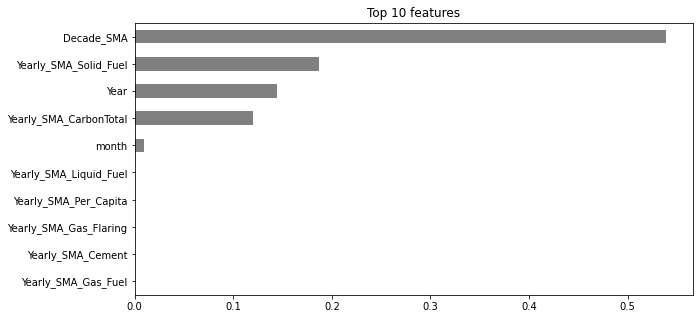

In [26]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)
# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [27]:
column  = ['Decade_SMA']

# Fit without column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train.drop(columns=column), y_train)
score_without = pipeline.score(X_val.drop(columns=column), y_val)
print(f'Validation Accuracy without {column}: {score_without}')

# Fit with column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train, y_train)
score_with = pipeline.score(X_val, y_val)
print(f'Validation Accuracy with {column}: {score_with}')

# Compare the error with & without column
print(f'Drop-Column Importance for {column}: {score_with - score_without}')

Validation Accuracy without ['Decade_SMA']: 0.9615384615384616
Validation Accuracy with ['Decade_SMA']: 1.0
Drop-Column Importance for ['Decade_SMA']: 0.038461538461538436


In [28]:
#Lets Exclude Decade_SMA

In [29]:
list(train)

['month',
 'Year',
 'Decade_SMA',
 'Global_Warming',
 'Yearly_SMA_Solid_Fuel',
 'Yearly_SMA_Gas_Fuel',
 'Yearly_SMA_Cement',
 'Yearly_SMA_Gas_Flaring',
 'Yearly_SMA_Per_Capita',
 'Yearly_SMA_Liquid_Fuel',
 'Yearly_SMA_CarbonTotal']

In [30]:
# Arrange data into X features matrix and y target vector
target = 'Global_Warming'
feature = ['month',
 'Year',
 'Yearly_SMA_Solid_Fuel',
 'Yearly_SMA_Gas_Fuel',
 'Yearly_SMA_Cement',
 'Yearly_SMA_Gas_Flaring',
 'Yearly_SMA_Per_Capita',
 'Yearly_SMA_Liquid_Fuel',
 'Yearly_SMA_CarbonTotal']
X_train = train[feature]
y_train = train[target]
X_val = val[feature]
y_val = val[target]
X_test = test[feature]
y_test = test[target]

In [31]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
#After Industrial Revolution(1850)
print(X_test.shape)
print(y_test.shape)

(830, 9)
(830,)
(208, 9)
(208,)
(1932, 9)
(1932,)


In [32]:
pipeline2 = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100,random_state=42, n_jobs=-1))
# Fit on train, score on test
pipeline2.fit(X_train, y_train)
print('Train Accuracy', pipeline2.score(X_train, y_train))
print('Validation Accuracy', pipeline2.score(X_val, y_val))
print('Test Accuracy', pipeline2.score(X_test, y_test))

Train Accuracy 1.0
Validation Accuracy 0.9615384615384616
Test Accuracy 0.6635610766045549


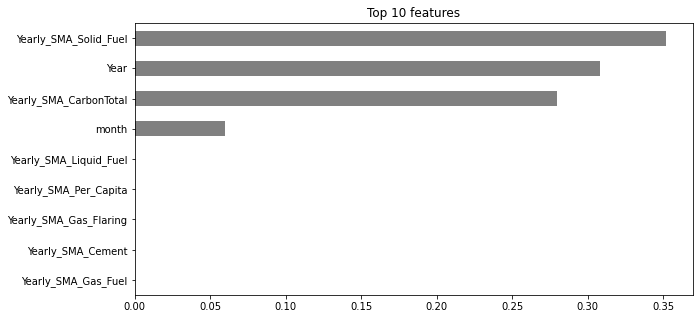

In [33]:
# Get feature importances
rf = pipeline2.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)
# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [34]:
column  = ['Year','month','Yearly_SMA_CarbonTotal']

# Fit without column
pipeline2 = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline2.fit(X_train.drop(columns=column), y_train)
score_without = pipeline2.score(X_val.drop(columns=column), y_val)
print(f'Validation Accuracy without {column}: {score_without}')

# Fit with column
pipeline2 = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline2.fit(X_train, y_train)
score_with = pipeline2.score(X_val, y_val)
print(f'Validation Accuracy with {column}: {score_with}')

# Compare the error with & without column
print(f'Drop-Column Importance for {column}: {score_with - score_without}')

Validation Accuracy without ['Year', 'month', 'Yearly_SMA_CarbonTotal']: 0.9471153846153846
Validation Accuracy with ['Year', 'month', 'Yearly_SMA_CarbonTotal']: 0.9615384615384616
Drop-Column Importance for ['Year', 'month', 'Yearly_SMA_CarbonTotal']: 0.014423076923076983


In [35]:
#Try Without time and carbon total

In [36]:
# Arrange data into X features matrix and y target vector
target = 'Global_Warming'
feature = ['Yearly_SMA_Solid_Fuel',
 'Yearly_SMA_Gas_Fuel',
 'Yearly_SMA_Cement',
 'Yearly_SMA_Gas_Flaring',
 'Yearly_SMA_Per_Capita',
 'Yearly_SMA_Liquid_Fuel']
X_train = train[feature]
y_train = train[target]
X_val = val[feature]
y_val = val[target]
X_test = test[feature]
y_test = test[target]

In [37]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
#After Industrial Revolution(1850)
print(X_test.shape)
print(y_test.shape)

(830, 6)
(830,)
(208, 6)
(208,)
(1932, 6)
(1932,)


In [ ]:
#Baseline for guessing need better than .993789

In [38]:
pipeline3 = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100,random_state=42, n_jobs=-1))
# Fit on train, score on test
pipeline3.fit(X_train, y_train)
print('Train Accuracy', pipeline3.score(X_train, y_train))
print('Validation Accuracy', pipeline3.score(X_val, y_val))
print('Test Accuracy', pipeline3.score(X_test, y_test))

Train Accuracy 0.9530120481927711
Validation Accuracy 0.9471153846153846
Test Accuracy 0.9937888198757764


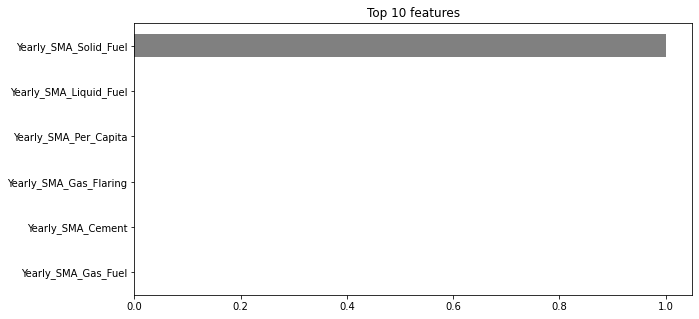

In [39]:
# Get feature importances
rf = pipeline3.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)
# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [41]:
column  = ['Yearly_SMA_Solid_Fuel']

# Fit without column
pipeline3 = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline3.fit(X_train.drop(columns=column), y_train)
score_without = pipeline3.score(X_val.drop(columns=column), y_val)
print(f'Validation Accuracy without {column}: {score_without}')

# Fit with column
pipeline3 = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline3.fit(X_train, y_train)
score_with = pipeline3.score(X_val, y_val)
print(f'Validation Accuracy with {column}: {score_with}')

# Compare the error with & without column
print(f'Drop-Column Importance for {column}: {score_with - score_without}')

Validation Accuracy without ['Yearly_SMA_Solid_Fuel']: 0.625
Validation Accuracy with ['Yearly_SMA_Solid_Fuel']: 0.9471153846153846
Drop-Column Importance for ['Yearly_SMA_Solid_Fuel']: 0.3221153846153846


In [ ]:
#Try Without solid fuel

In [42]:
# Arrange data into X features matrix and y target vector
target = 'Global_Warming'
feature = ['Yearly_SMA_Gas_Fuel',
 'Yearly_SMA_Cement',
 'Yearly_SMA_Gas_Flaring',
 'Yearly_SMA_Per_Capita',
 'Yearly_SMA_Liquid_Fuel']
X_train = train[feature]
y_train = train[target]
X_val = val[feature]
y_val = val[target]
X_test = test[feature]
y_test = test[target]

In [43]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
#After Industrial Revolution(1850)
print(X_test.shape)
print(y_test.shape)

(830, 5)
(830,)
(208, 5)
(208,)
(1932, 5)
(1932,)


In [44]:
pipeline4 = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100,random_state=42, n_jobs=-1))
# Fit on train, score on test
pipeline4.fit(X_train, y_train)
print('Train Accuracy', pipeline4.score(X_train, y_train))
print('Validation Accuracy', pipeline4.score(X_val, y_val))
print('Test Accuracy', pipeline4.score(X_test, y_test))

Train Accuracy 0.6253012048192771
Validation Accuracy 0.625
Test Accuracy 0.9937888198757764


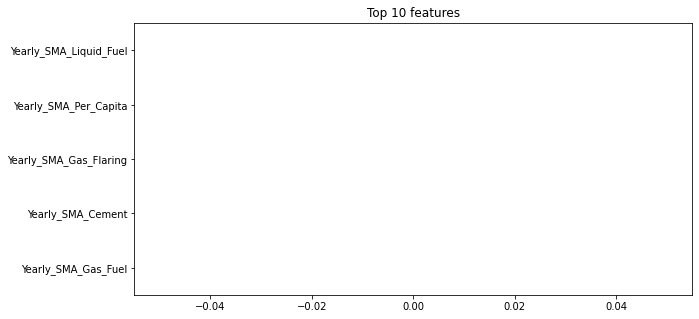

In [45]:
# Get feature importances
rf = pipeline4.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)
# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

### 3) Try xgboost.

In [79]:
from xgboost import XGBClassifier
XGBClassifier?

In [80]:
pipeline6 = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=6)
)

pipeline6.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=6, nthread=None,
                               objective='binary:logistic', random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
       

In [ ]:
#Baseline for guessing need better than .993789

In [81]:
print('Training Accuracy:', pipeline6.score(X_train, y_train))
print('Validation Accuracy:', pipeline6.score(X_val, y_val))
print('Validation Accuracy:', pipeline.score(X_test, y_test))

Training Accuracy: 1.0
Validation Accuracy: 1.0
Validation Accuracy: 0.9979296066252588


In [86]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
model = XGBClassifier(
    n_estimators = 1000,
    max_depth=7,
    learning_rate=0.5,
    n_jobs=-1)
eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]
model.fit(X_train_encoded, y_train, 
          eval_set=eval_set, 
          eval_metric='merror', 
          early_stopping_rounds=50) # Stop if the score hasn't improved in 50 rounds

XGBoostError: ignored

### 4) Get your model's permutation importances.

In [51]:
from sklearn.inspection import permutation_importance

In [55]:
result = permutation_importance(pipeline, X_val, y_val, 
                                n_repeats=5, random_state=0)

In [57]:
Importance = pd.DataFrame({'feature': X_val.columns,
                   'importances_mean': np.round(result['importances_mean'], 3),
                   'importances_std': result['importances_std']})
Importance.sort_values(by='importances_mean', ascending=False)

,feature,importances_mean,importances_std
2,Decade_SMA,0.463,0.034881
0,month,0.000,0.000000
1,Year,0.000,0.000000
3,Yearly_SMA_Solid_Fuel,0.000,0.000000
4,Yearly_SMA_Gas_Fuel,0.000,0.000000
5,Yearly_SMA_Cement,0.000,0.000000
6,Yearly_SMA_Gas_Flaring,0.000,0.000000
7,Yearly_SMA_Per_Capita,0.000,0.000000
8,Yearly_SMA_Liquid_Fuel,0.000,0.000000
9,Yearly_SMA_CarbonTotal,0.000,0.000000


In [58]:
result = permutation_importance(pipeline, X_test, y_test, 
                                n_repeats=5, random_state=0)

In [59]:
Importance = pd.DataFrame({'feature': X_test.columns,
                   'importances_mean': np.round(result['importances_mean'], 3),
                   'importances_std': result['importances_std']})
Importance.sort_values(by='importances_mean', ascending=False)

,feature,importances_mean,importances_std
2,Decade_SMA,0.008,0.0
0,month,0.000,0.0
1,Year,0.000,0.0
3,Yearly_SMA_Solid_Fuel,0.000,0.0
4,Yearly_SMA_Gas_Fuel,0.000,0.0
5,Yearly_SMA_Cement,0.000,0.0
6,Yearly_SMA_Gas_Flaring,0.000,0.0
7,Yearly_SMA_Per_Capita,0.000,0.0
8,Yearly_SMA_Liquid_Fuel,0.000,0.0
9,Yearly_SMA_CarbonTotal,0.000,0.0


In [60]:
# Ignore warnings
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [66]:
#Install non-standard packages (assuming jupyter notebook)
!pip install shap
!pip install lime
!pip install eli5

     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394112 sha256=40d18d8e4b00bb2e628e11ca5837647f57d80c994836fbec358203e707e14eb3
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap
     |████████████████████████████████| 276kB 2.7MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283845 sha256=795b34f7088882a876e67f8c6ee31d3920ae886db57839dadadfc2899d094561
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime
     |████████████████████████████████| 112kB 2.6MB/s 


In [67]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
#scikit-learn package (https://pypi.org/project/scikit-learn)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.metrics.scorer import make_scorer
#eli5 package (https://eli5.readthedocs.io/en/latest)
import eli5
from eli5.sklearn import PermutationImportance
#lime package (https://github.com/marcotcr/lime)
import lime
import lime.lime_tabular
#shap package (https://github.com/slundberg/shap)
import shap

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [68]:
import eli5 as eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [69]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=X_val.columns.tolist()
)

Weight,Feature
0.4654 ± 0.0477,Decade_SMA
0 ± 0.0000,Yearly_SMA_CarbonTotal
0 ± 0.0000,Yearly_SMA_Liquid_Fuel
0 ± 0.0000,Yearly_SMA_Per_Capita
0 ± 0.0000,Yearly_SMA_Gas_Flaring
0 ± 0.0000,Yearly_SMA_Cement
0 ± 0.0000,Yearly_SMA_Gas_Fuel
0 ± 0.0000,Yearly_SMA_Solid_Fuel
0 ± 0.0000,Year
0 ± 0.0000,month


In [70]:
from sklearn.ensemble import GradientBoostingClassifier

In [73]:
pipeline5 = make_pipeline(
    ce.OrdinalEncoder(), 
    #SimpleImputer(strategy='median'), 
    GradientBoostingClassifier()
)

pipeline5.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(ccp_alpha=0.0,
                                            criterion='friedman_mse', init=None,
                                            learning_rate=0.1, loss='deviance',
                                            max_depth=3, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_we

In [ ]:
#Baseline for guessing need better than .993789

In [75]:
print('Training Accuracy:', pipeline5.score(X_train, y_train))
print('Validation Accuracy:', pipeline5.score(X_val, y_val))
print('Validation Accuracy:', pipeline5.score(X_test, y_test))

Training Accuracy: 1.0
Validation Accuracy: 1.0
Validation Accuracy: 0.9979296066252588
